## Environment setup

In [2]:
# Standard Library Imports
import os
import warnings

# Data handling and numerical operations
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing libraries
import nltk
from wordcloud import WordCloud, STOPWORDS

# Text vectorization and machine learning
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Utility libraries
import chardet
from collections import Counter
from joblib import dump, load
from urllib.parse import urlparse

# Function definitions
def get_base_url(url):
    """
    Extract the base domain from a given URL, removing 'www.' if it starts with it.
    """
    if isinstance(url, str):
        parsed_url = urlparse(url)  # Parse the URL to separate components
        base_url = parsed_url.netloc  # Extract the network location part (base domain)

        if base_url.startswith('www.'):
            base_url = base_url[4:]  # Remove 'www.' prefix

        return base_url
    else:
        return None  # Return None for non-string input

# Configuration
warnings.filterwarnings("ignore")  # Ignore warnings from plt

In [3]:
# Downloading NLTK resources
nltk.download('punkt', quiet=True)                              # Sentence tokenization
nltk.download('stopwords', quiet=True)                          # Stopwords list essential for NLP

True

## Data loading and preprocessing

### Reading the raw data

In [4]:
# List to store dataframes
datasets = []

# Load data and labels for dataset DS1
data_ds1 = pd.read_csv('../Datasets/DS1/Data.csv', encoding='utf-8')
labels_ds1 = pd.read_csv('../Datasets/DS1/Labels.csv', encoding='utf-8')

# Combine data and labels into a single DataFrame for DS1
combined_ds1 = pd.concat([data_ds1, labels_ds1['sentiment']], axis=1)
datasets.append(('DS1', 'Financial Tweets', combined_ds1))

# Detect the encoding of the dataset DS2
with open('../Datasets/DS2/Data.csv', 'rb') as file:
    encoding_detection = chardet.detect(file.read(10000))

# Load dataset DS2 with detected encoding
data_ds2 = pd.read_csv('../Datasets/DS2/Data.csv', encoding=encoding_detection['encoding'])
datasets.append(('DS2', 'Financial Phrasebank', data_ds2))

# Load datasets DS3, DS4, and DS5 with default encoding (utf-8)
data_ds3 = pd.read_csv('../Datasets/DS3/Data.csv', encoding='utf-8')
data_ds4 = pd.read_csv('../Datasets/DS4/Data.csv', encoding='utf-8')
data_ds5 = pd.read_csv('../Datasets/DS5/Data.csv', encoding='utf-8')

datasets.extend([('DS3', 'FiQA', data_ds3), ('DS4', 'Stock Tweets', data_ds4), ('DS5', 'Cryptocurrency Reddit Comments', data_ds5)])

### Preliminary data exploration

In [5]:
# Loop through each dataset and print its info and a sample
for name, description, dataset in datasets:
    print(f"{'=' * 40}")
    print(f"Dataset: {name} - {description}")
    print(f"{'=' * 40}")
    print("Info:")
    display(dataset.info())
    print("\nSample Data:")
    display(dataset.head())
    print("\n")

Dataset: DS1 - Financial Tweets
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28440 entries, 0 to 28439
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             28440 non-null  object
 1   text           28440 non-null  object
 2   timestamp      28438 non-null  object
 3   source         28437 non-null  object
 4   symbols        28437 non-null  object
 5   company_names  28435 non-null  object
 6   url            22049 non-null  object
 7   verified       28436 non-null  object
 8   sentiment      28440 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.0+ MB


None


Sample Data:


,id,text,timestamp,source,symbols,company_names,url,verified,sentiment
0,1.0197E+18,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,TRUE,0
1,1.01971E+18,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,TRUE,0
2,1.01971E+18,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,TRUE,-1
3,1.01972E+18,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,TRUE,1
4,1.01972E+18,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,TRUE,-1




Dataset: DS2 - Financial Phrasebank
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                           --------------  ----- 
 0   neutral                                                                                                                          4845 non-null   object
 1   According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .  4845 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


None


Sample Data:


,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...




Dataset: DS3 - FiQA
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


None


Sample Data:


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral




Dataset: DS4 - Stock Tweets
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Stock Ticker  500 non-null    object
 1   Tweet Text    500 non-null    object
 2   Sentiment     500 non-null    object
 3   Tweet URL     500 non-null    object
dtypes: object(4)
memory usage: 15.8+ KB


None


Sample Data:


,Stock Ticker,Tweet Text,Sentiment,Tweet URL
0,$TSLA,"Ruh-roh, *someone's* first ex wife is dancing ...",Negative,https://twitter.com/MelaynaLokosky/status/1526...
1,$PARA,"Nice 9% pre market move for $para, pump my cal...",Positive,https://twitter.com/option_oracle/status/15264...
2,$HD,"I'm an investor in $LOW, but I have no problem...",Positive,https://twitter.com/scottsinvesting/status/152...
3,$TSLA,Everyone knew you would back out of the deal w...,Negative,https://twitter.com/Barnacules/status/15264897...
4,$TSLA,"SELL EVERYTHING, BUY $TSLA 🚀🌕",Positive,https://twitter.com/valueanalyst1/status/15255...




Dataset: DS5 - Cryptocurrency Reddit Comments
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Comment Text  562 non-null    object
 1   Sentiment     562 non-null    object
 2   URL           562 non-null    object
dtypes: object(3)
memory usage: 13.3+ KB


None


Sample Data:


,Comment Text,Sentiment,URL
0,BTC should be in everyone’s Portfolio,Positive,https://www.reddit.com/r/CryptoCurrency/commen...
1,No one has convinced me that crypto as an inve...,Negative,https://www.reddit.com/r/Fire/comments/sshdm8/...
2,I think it can be very dependable if you pick ...,Positive,https://www.reddit.com/r/CryptoCurrency/commen...
3,Bear market is over. Nothing but green candles...,Positive,https://www.reddit.com/r/CryptoCurrency/commen...
4,"I've posted this before, but regulation (parti...",Positive,https://old.reddit.com/r/CryptoCurrency/commen...


### Read pre-processed data

In [14]:
df = pd.read_feather('../Data/Full_Data.feather')

df_145 = pd.read_feather('../Data/Data145.feather')

df_1 = pd.read_feather('../Data/Data1.feather')

## Exploratory data analysis (EDA)

### Sentiment distribution

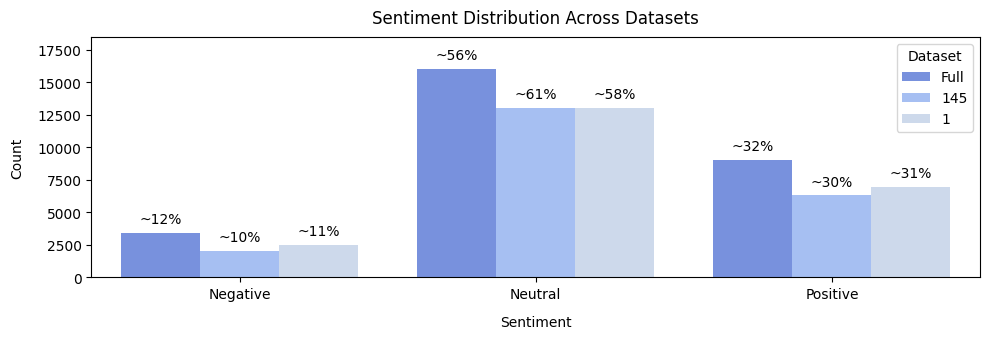

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define colors for the plots using Seaborn's color palette
colors = sns.color_palette("coolwarm")

# Prepare the data by creating a combined dataframe with a new 'Source' column
dfs = [df, df_1, df_145]
source_labels = ['df', 'df_1', 'df_145']
combined_data = pd.concat([data.assign(Source=label) for data, label in zip(dfs, source_labels)])

# Calculate counts for each source and sentiment combination
counts = combined_data.groupby(['Source', 'sentiment']).size().reset_index(name='count')
total_counts = combined_data.groupby('Source').size().reset_index(name='total')

# Merge the counts with total counts to calculate percentages
counts = counts.merge(total_counts, on='Source')
counts['percentage'] = counts['count'] / counts['total'] * 100

# Create a figure
plt.figure(figsize=(10, 3.5))

# Create a grouped bar plot using a Seaborn color palette
ax = sns.barplot(x='sentiment', y='count', hue='Source', data=counts, palette=colors)

# Annotate percentages on each bar
for p, perc in zip(ax.patches, counts['percentage']):
    height = p.get_height()
    plt.gca().annotate(f'~{perc:.0f}%', (p.get_x() + p.get_width() / 2., height), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                       textcoords='offset points')

plt.title('Sentiment Distribution Across Datasets', fontsize=12, pad=10)
plt.xlabel('Sentiment', labelpad=10)
plt.ylabel('Count', labelpad=10)
# set y lim
plt.ylim(0, 18500)
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

# Customizing legend entries
handles, labels = ax.get_legend_handles_labels()
custom_labels = ['Full', '145', '1']
ax.legend(handles, custom_labels, title='Dataset')

plt.tight_layout()

plt.savefig('../Figs/EDA_sentiment_distribution.png', dpi=500)

plt.show()


### Word clouds

In [9]:
positive_text = []
negative_text = []
neutral_text = []

for i in range(0,df.shape[0]):
    if df['sentiment'][i] == 0:
        neutral_text.append(df['text'][i])
    elif df['sentiment'][i] == 1:
        positive_text.append(df['text'][i])
    elif df['sentiment'][i] == -1:
        negative_text.append(df['text'][i])

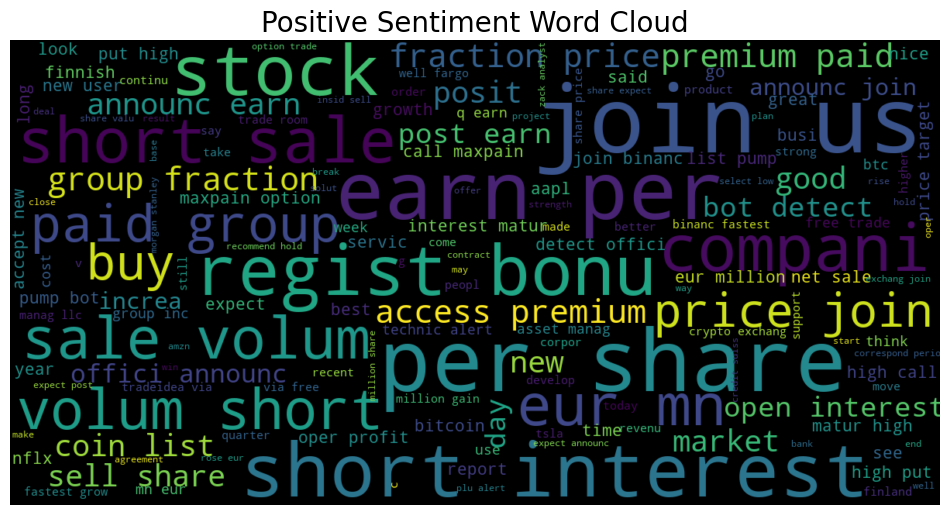

Most Common Words in 'Positive Sentiment Word Cloud':
share: 1487
inc: 1054
short: 912
join: 853
stock: 848
price: 766
earn: 761
us: 741
interest: 658
eur: 658


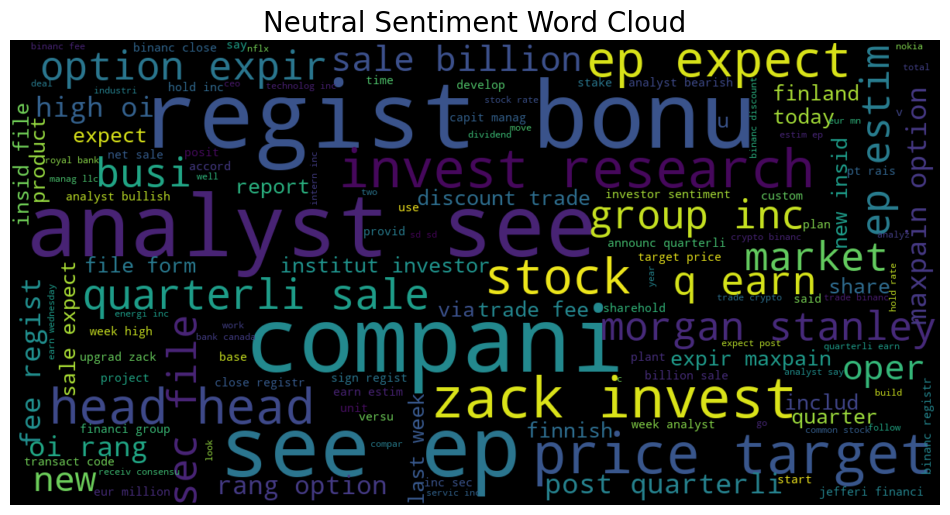

Most Common Words in 'Neutral Sentiment Word Cloud':
inc: 2534
analyst: 1475
ep: 1204
stock: 1151
expect: 1066
compani: 1041
price: 947
group: 882
trade: 868
earn: 822


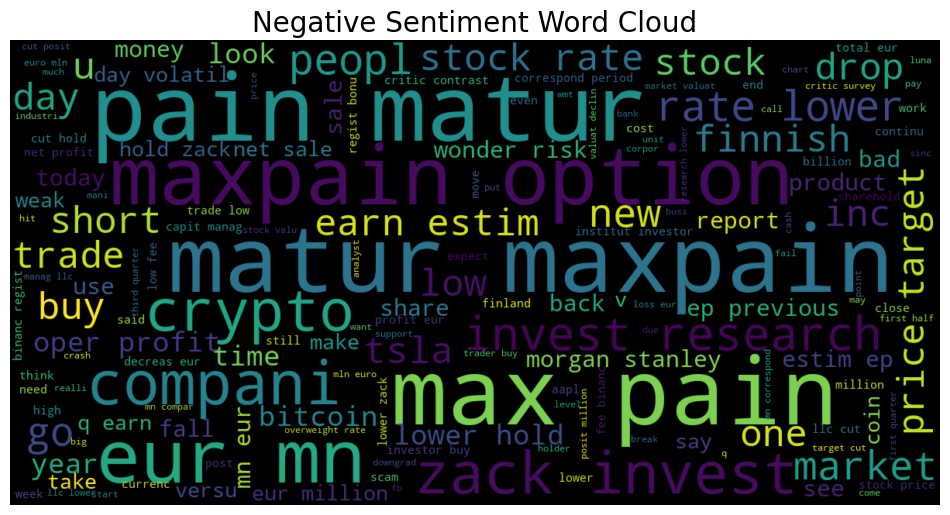

Most Common Words in 'Negative Sentiment Word Cloud':
lower: 504
eur: 421
option: 304
stock: 302
pain: 301
max: 292
matur: 292
maxpain: 290
inc: 276
cut: 256


In [10]:
STOPWORDS = set(STOPWORDS)

def show_wordcloud(data, title=None):
    combined_text = ' '.join(data)

    wordcloud = WordCloud(
        background_color='black',
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(combined_text)

    # Setting up the plot
    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

    if title:
        plt.title(title, fontsize=20)

    plt.show()

    # Generating a text summary of the most frequent words
    words = [word for word in combined_text.lower().split() if word not in STOPWORDS]
    word_freq = Counter(words)
    most_common_words = word_freq.most_common(10)

    print(f"Most Common Words in '{title}':")
    for word, freq in most_common_words:
        print(f"{word}: {freq}")

show_wordcloud(positive_text, title="Positive Sentiment Word Cloud")
show_wordcloud(neutral_text, title="Neutral Sentiment Word Cloud")
show_wordcloud(negative_text, title="Negative Sentiment Word Cloud")

## Feature engineering

### N-gram analysis

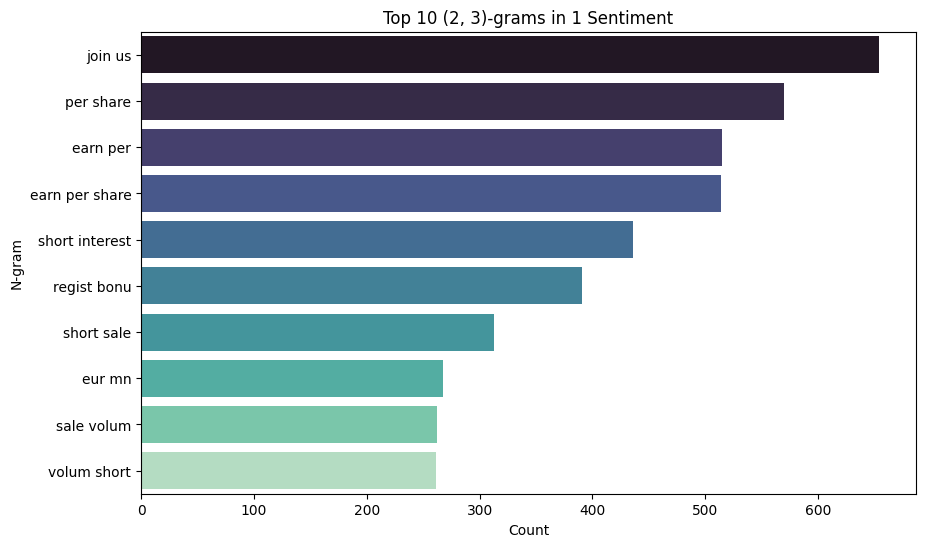

Top 10 (2, 3)-grams in 1 Sentiment:
           N-gram  Count
0         join us    654
1       per share    570
2        earn per    515
3  earn per share    514
4  short interest    436
5     regist bonu    391
6      short sale    313
7          eur mn    268
8      sale volum    262
9     volum short    261


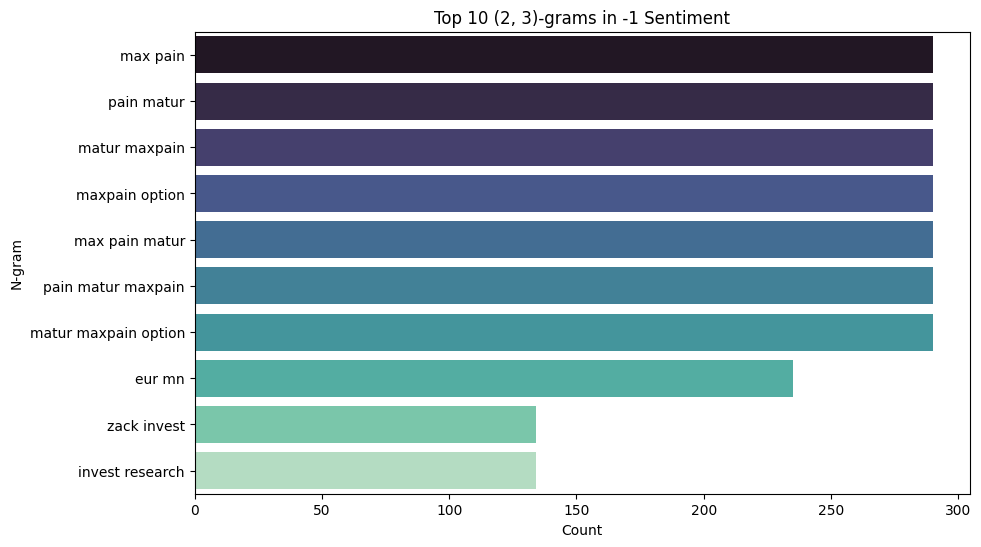

Top 10 (2, 3)-grams in -1 Sentiment:
                 N-gram  Count
0              max pain    290
1            pain matur    290
2         matur maxpain    290
3        maxpain option    290
4        max pain matur    290
5    pain matur maxpain    290
6  matur maxpain option    290
7                eur mn    235
8           zack invest    134
9       invest research    134


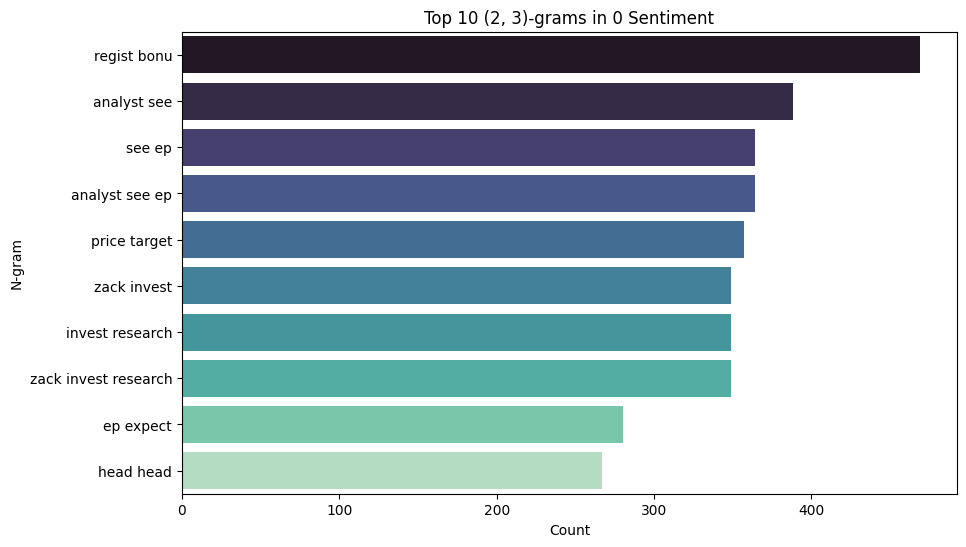

Top 10 (2, 3)-grams in 0 Sentiment:
                 N-gram  Count
0           regist bonu    469
1           analyst see    388
2                see ep    364
3        analyst see ep    364
4          price target    357
5           zack invest    349
6       invest research    349
7  zack invest research    349
8             ep expect    280
9             head head    267


In [11]:
# Analyzing common bigrams and trigrams
def plot_top_ngrams(sentiment, n=10, ngram_range=(2, 3)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    ngrams = vectorizer.fit_transform(df[df['sentiment'] == sentiment]['text'])
    ngrams_sum = ngrams.sum(axis=0)
    ngrams_freq = [(word, ngrams_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:n]

    ngrams_df = pd.DataFrame(ngrams_freq, columns=['N-gram', 'Count'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='N-gram', data=ngrams_df, palette='mako')
    plt.title(f'Top {n} {ngram_range}-grams in {sentiment} Sentiment')
    plt.show()

    # print the top 10 n-grams
    print(f"Top {n} {ngram_range}-grams in {sentiment} Sentiment:")
    print(ngrams_df)

plot_top_ngrams(1)
plot_top_ngrams(-1)
plot_top_ngrams(0)

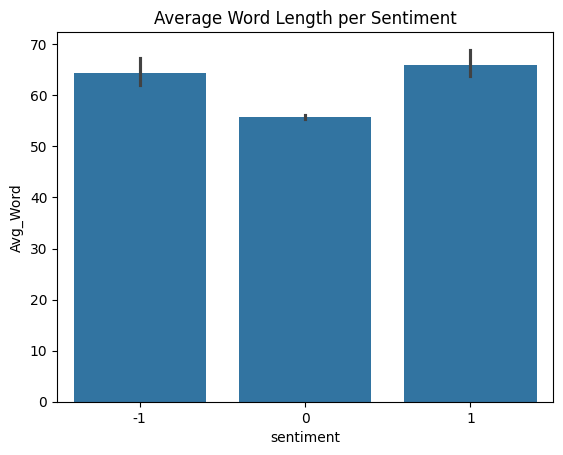

Average Word Length per Sentiment:
sentiment
-1    64.417032
 0    55.680980
 1    65.967574
Name: Avg_Word, dtype: float64


In [12]:
# Average word per sentiment
df['Avg_Word'] = df['text'].apply(lambda x: np.mean(len(x)))
sns.barplot(x='sentiment', y='Avg_Word', data=df)
plt.title('Average Word Length per Sentiment')
plt.show()

# Print results
print("Average Word Length per Sentiment:")
print(df.groupby('sentiment')['Avg_Word'].mean())

### Vectorisation techniques

Top 10 words:


inc        843.389368
stock      541.701804
share      515.383086
analyst    512.965046
price      506.325717
expect     481.446087
ep         475.005120
earn       454.586701
trade      433.730947
compani    431.868597
dtype: float64

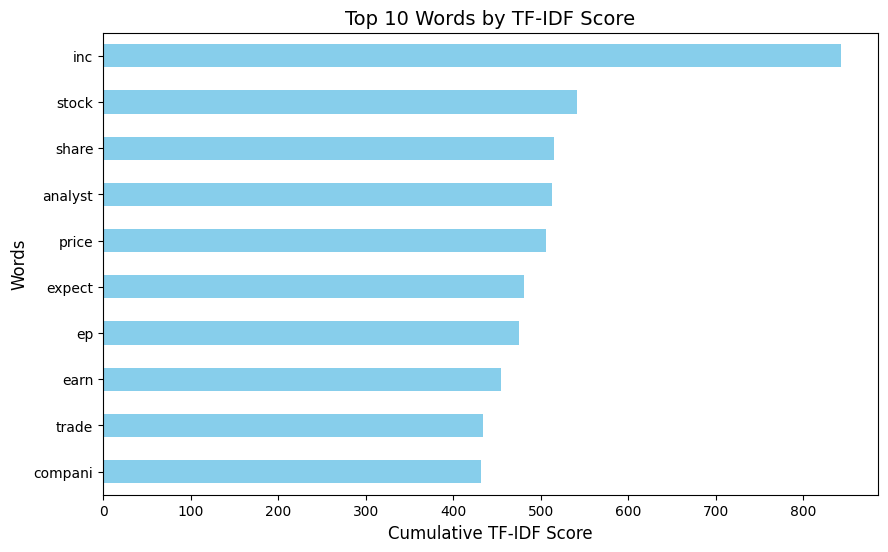

Concise TF-IDF Statistics:


,aaba,aal,aaoi,aap,aapl,abbv,abc,abt,accept,access,...,xlnx,xom,year,yesterday,yet,yndx,yum,zack,zoeti,zt
mean,0.001102,0.001630,0.001119,0.000939,0.004151,0.001112,0.001415,0.001178,0.001762,0.003424,...,0.001096,0.001220,0.007365,0.001021,0.000871,0.001088,0.001359,0.008533,0.000754,0.001045
std,0.025291,0.030353,0.025775,0.020521,0.038976,0.021679,0.026322,0.023374,0.030129,0.035718,...,0.024717,0.022696,0.050438,0.022068,0.020434,0.025221,0.031114,0.054331,0.019124,0.021686
max,0.824435,1.000000,1.000000,0.846572,1.000000,1.000000,0.840034,1.000000,1.000000,0.584563,...,0.746238,0.761725,0.862087,0.801100,1.000000,1.000000,1.000000,0.500989,0.813656,0.652314



Words with Highest Variance:


,mean,std,max
inc,0.029626,0.081072,1.000000
short,0.013486,0.080764,1.000000
ep,0.016686,0.076815,0.628270
expect,0.016912,0.074280,0.614590
eur,0.012587,0.073655,1.000000
trade,0.015236,0.071156,0.878693
head,0.007899,0.070891,1.000000
share,0.018104,0.070733,1.000000
analyst,0.018019,0.070433,0.590830
stock,0.019028,0.070093,1.000000



Words with Lowest Variance:


,mean,std,max
estat,0.000760,0.016369,0.614001
nine,0.000738,0.016467,0.681612
uso,0.000753,0.016940,0.719858
vtr,0.000760,0.016992,0.717150
tvix,0.000787,0.017643,0.735732
xlf,0.000780,0.017670,0.603386
unh,0.000876,0.017823,0.585221
lyondellbasel,0.000687,0.017829,0.574553
vix,0.000918,0.017846,0.691037
extra,0.000784,0.018073,0.577611


In [13]:
# TF-IDF Vectorization with custom stop words
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

top_words = tfidf_df.sum(axis=0).sort_values(ascending=False).head(10)
print("Top 10 words:")
display(top_words)

plt.figure(figsize=(10, 6))
top_words.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Words by TF-IDF Score', fontsize=14)
plt.xlabel('Cumulative TF-IDF Score', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

tfidf_stats = tfidf_df.agg(['mean', 'std', 'max'])
print("Concise TF-IDF Statistics:")
display(tfidf_stats)

high_variance_words = tfidf_stats.transpose().sort_values(by='std', ascending=False).head(10)
print("\nWords with Highest Variance:")
display(high_variance_words)

low_variance_words = tfidf_stats.transpose().sort_values(by='std', ascending=True).head(10)
print("\nWords with Lowest Variance:")
display(low_variance_words)

# Topics Extractions

### Implementing latent dirichlet allocation

In [14]:
vectorizer_path = 'lda_vectorizer.joblib'
model_path = 'best_lda_model.joblib'

if os.path.exists(vectorizer_path):
    vectorizer = load(vectorizer_path)

vectorizer = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')

if not os.path.exists(vectorizer_path):
    dump(vectorizer, vectorizer_path)

X = vectorizer.fit_transform(df['text'])

if os.path.exists(model_path):
    best_lda_model = load(model_path)
else:
    # Setting up LDA with GridSearch for parameter tuning
    lda = LatentDirichletAllocation(random_state=42)
    params = {'n_components': [2, 3, 4, 5], 'learning_decay': [.5, .7, .9]}
    grid_search = GridSearchCV(lda, param_grid=params, cv=5)
    grid_search.fit(X)

    best_lda_model = grid_search.best_estimator_

    if not os.path.exists(model_path):
        dump(best_lda_model, model_path)

In [16]:
# Evaluate LDA Model
print(f"Best LDA Model: {best_lda_model}")
print(f"Log Likelihood: {best_lda_model.score(X)}")
print(f"Perplexity: {best_lda_model.perplexity(X)}")

# Topics visualization
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(" ".join([f"{feature_names[i]} ({topic[i]:.2f})"
                        for i in topic.argsort()[-no_top_words:]]))

no_top_words = 10
display_topics(best_lda_model, vectorizer.get_feature_names_out(), no_top_words)

Best LDA Model: LatentDirichletAllocation(learning_decay=0.5, n_components=2, random_state=42)
Log Likelihood: -2043095.1178771518
Perplexity: 2303.721788020913

Topic 1:
regist (1035.48) short (1189.34) option (1232.42) earn (1252.23) trade (1276.21) ep (1328.69) sale (1399.44) compani (1422.81) eur (1455.49) expect (1521.80)

Topic 2:
target (878.98) group (974.02) rate (1046.88) share (1098.33) invest (1137.63) buy (1216.41) hold (1348.36) analyst (1471.68) price (1496.35) stock (2286.90)


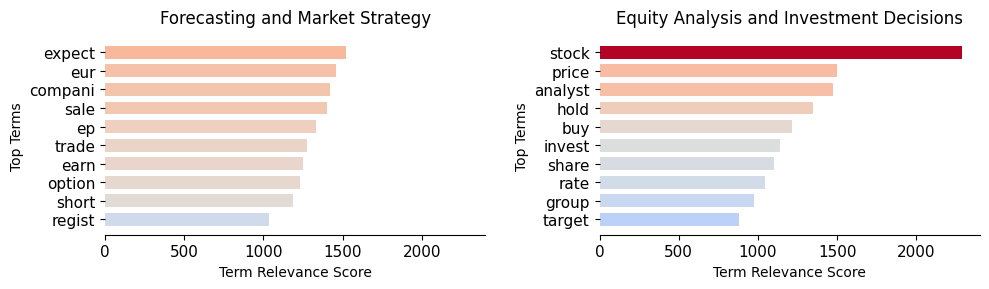

In [ ]:
# Visualizing the topics-keywords distribution
def plot_top_words(model, feature_names, n_top_words, title):
    n_topics = model.n_components
    cols = 2
    rows = n_topics // cols + (n_topics % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(10, 3), sharex=True)
    axes = axes.flatten()
    
    global_weights = []
    for topic in model.components_:
        global_weights.extend(topic)
    max_weight = max(global_weights)
    min_weight = min(global_weights)
    norm = plt.Normalize(min_weight, max_weight)
    colors = sns.color_palette("coolwarm", as_cmap=True)

    topics = {
        1:"Forecasting and Market Strategy",
        2:"Equity Analysis and Investment Decisions",
    }

    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < len(axes):  # This check is to avoid index error
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bars = ax.barh(top_features, weights, height=0.7, color=colors(norm(weights)))
            ax.set_title(f'{topics[topic_idx + 1]}', fontsize=12, pad=10)
            ax.invert_yaxis()
            # set x axis label
            ax.set_ylabel('Top Terms', fontsize=10)
            ax.set_xlabel('Term Relevance Score', fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=11)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
        else:
            axes[topic_idx].axis('off')
    # plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.savefig("EDA_LDA_topic_distribution.png", dpi=500)
    plt.show()

# Plotting the top words for the number of topics in the model
plot_top_words(best_lda_model, vectorizer.get_feature_names_out(), no_top_words, 'Thematic Word Distributions Derived from Financial Texts Using LDA')

# Bias Analysis

## Dataset 1

### Source (Base URL) Sentiment Distribution

In [17]:
# Rename the dataset for clarity
financial_tweets_dataset = df_1

# Analyze and display the top news sources based on the number of articles
news_source_frequencies = financial_tweets_dataset['base_url'].value_counts()
print("Top Sources (Base URL):")
print(news_source_frequencies.head(10))

Top Sources (Base URL):
base_url
twitter.com             4262
zpr.io                  1483
binance.com              935
seekingalpha.com         920
bibeypost.com            913
whatsonthorold.com       899
mmahotstuff.com          836
mareainformativa.com     636
reurope.com              635
maximum-pain.com         537
Name: count, dtype: int64


<Figure size 1200x800 with 0 Axes>

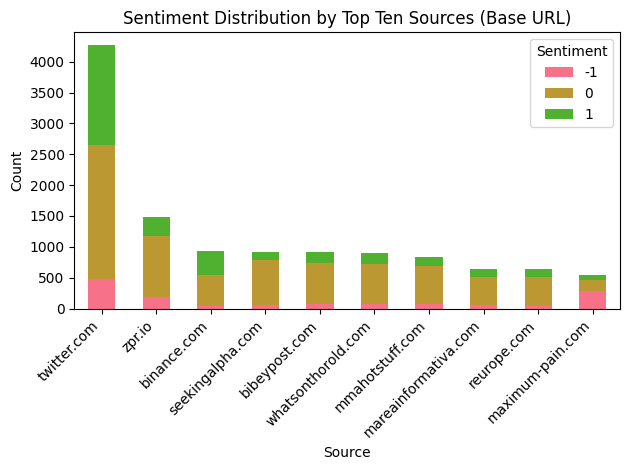

Sentiment Distribution by Top Ten Sources (Base URL):


sentiment,-1,0,1
base_url,,,
twitter.com,474,2170,1618
zpr.io,190,989,304
binance.com,37,503,395
seekingalpha.com,53,739,128
bibeypost.com,69,676,168
whatsonthorold.com,74,651,174
mmahotstuff.com,74,610,152
mareainformativa.com,60,451,125
reurope.com,43,470,122


In [11]:
# Calculate sentiment distribution for each news source and plot for the top ten sources
news_sentiment_distribution = financial_tweets_dataset.groupby(['base_url', 'sentiment']).size().unstack(fill_value=0)
top_news_sources = news_sentiment_distribution.sum(axis=1).nlargest(10).index
news_sentiment_top_ten = news_sentiment_distribution.loc[top_news_sources]

plt.figure(figsize=(12, 8))
sns.set_palette("husl")
news_sentiment_top_ten.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Top Ten Sources (Base URL)')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig("EDA_sentiment_distribution_by_source.png", dpi=500)
plt.show()

# Display results
print("Sentiment Distribution by Top Ten Sources (Base URL):")
display(news_sentiment_top_ten)

### Company Names Sentiment Distribution

<Figure size 1200x800 with 0 Axes>

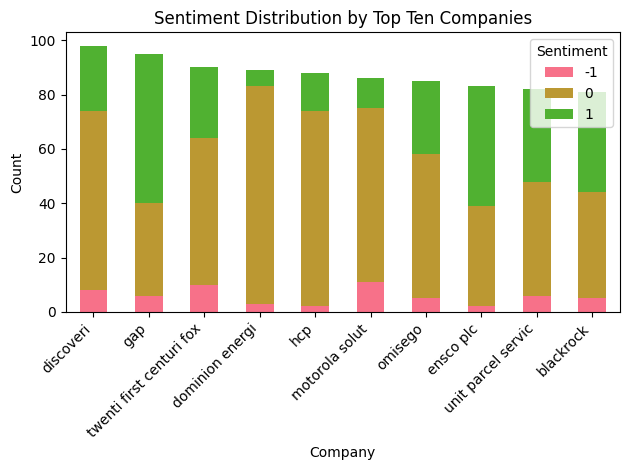

Top Companies Sentiment Distribution:


sentiment,-1,0,1
company_names,,,
discoveri,8,66,24
gap,6,34,55
twenti first centuri fox,10,54,26
dominion energi,3,80,6
hcp,2,72,14
motorola solut,11,64,11
omisego,5,53,27
ensco plc,2,37,44
unit parcel servic,6,42,34


In [12]:
# Calculate sentiment distribution for each company and plot for the top ten companies
company_sentiment_distribution = financial_tweets_dataset.groupby(['company_names', 'sentiment']).size().unstack(fill_value=0)
top_companies = company_sentiment_distribution.sum(axis=1).nlargest(10).index
company_sentiment_top_ten = company_sentiment_distribution.loc[top_companies]

plt.figure(figsize=(12, 8))
sns.set_palette("husl")
company_sentiment_top_ten.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Top Ten Companies')
plt.xlabel('Company')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig("EDA_sentiment_distribution_by_company.png", dpi=500)
plt.show()

# display the results and sentiment distribution for the top companies
print("Top Companies Sentiment Distribution:")
display(company_sentiment_top_ten)

## Dataset 1 + 4 + 5


### Source (Base URL) Sentiment Distribution

<Figure size 1200x800 with 0 Axes>

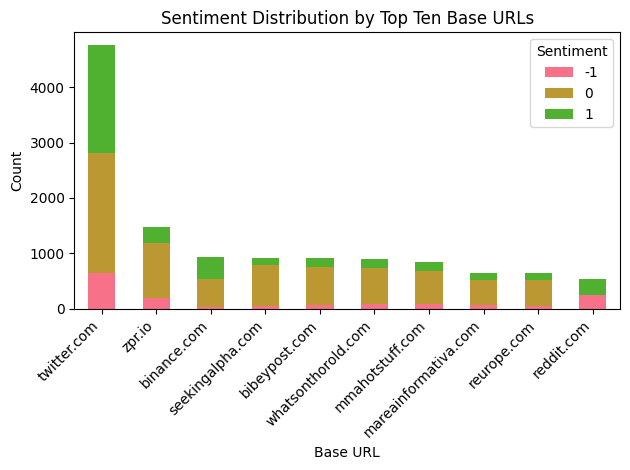

Top Base URLs Sentiment Distribution:


sentiment,-1,0,1
base_url,,,
twitter.com,647,2170,1937
zpr.io,190,989,304
binance.com,37,503,395
seekingalpha.com,53,739,128
bibeypost.com,69,676,168
whatsonthorold.com,74,651,174
mmahotstuff.com,74,610,152
mareainformativa.com,60,451,125
reurope.com,43,470,122


In [43]:
base_url_sentiment_distribution = df_145.groupby(['base_url', 'sentiment']).size().unstack(fill_value=0)
top_base_urls = base_url_sentiment_distribution.sum(axis=1).nlargest(10).index
base_url_sentiment_top_ten = base_url_sentiment_distribution.loc[top_base_urls]

plt.figure(figsize=(12, 8))
sns.set_palette("husl")
base_url_sentiment_top_ten.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Top Ten Base URLs')
plt.xlabel('Base URL')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

print("Top Base URLs Sentiment Distribution:")
display(base_url_sentiment_top_ten)